In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from ruler_generator import RulerGenerator, merge_images
from tensorflow.python.ops.numpy_ops import np_config
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

np_config.enable_numpy_behavior()

2023-04-22 13:39:48.685383: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-22 13:39:48.715378: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
list_ds = tf.data.Dataset.list_files('data/Sketches/input_data/*')

2023-04-22 13:39:49.964753: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-22 13:39:49.980052: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-22 13:39:49.980161: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
def get_image(image):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image

In [4]:
def add_lines(image):
    image = (image*255).astype('uint8')
    image = Image.fromarray(image.numpy())
    image = ImageEnhance.Contrast(image).enhance(2)
    i_size = image.size
    
    kwargs = {'shape': i_size,
  'line_width': np.random.randint(1,4),
  'lines': np.random.randint(15,40),
  'v_offset': np.random.random(),
  'raggedness': .3 + np.random.random()/2,
  'color': np.random.randint(100, 150),
  'color_variation': np.random.randint(15, 30),
  'angle': np.random.randint(-10, 11)}
    rg = RulerGenerator(**kwargs)
    image = Image.blend(image, rg.image, .2)
    
    return image

def tf_add_lines(image):
    [j] = tf.py_function(add_lines, [image], [tf.float32])
    j = tf.math.divide(j, 255)
    
    return j, image

2023-04-22 13:40:58.990807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [669]
	 [[{{node Placeholder/_0}}]]
2023-04-22 13:40:58.990930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [669]
	 [[{{node Placeholder/_0}}]]


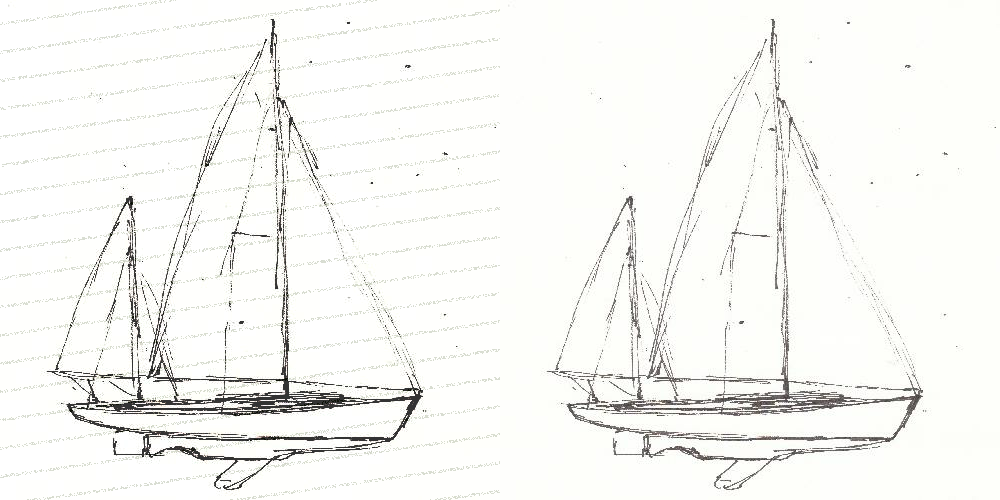

In [7]:
image_ds = list_ds.map(get_image)
image_ds = image_ds.map(tf.image.random_flip_left_right)
image_ds = image_ds.map(tf.image.random_flip_up_down)
train_ds = image_ds.map(tf_add_lines)
x, y = next(iter(train_ds.take(1)))
train_ds = train_ds.repeat()
train_ds = train_ds.shuffle(buffer_size=20)
train_ds = train_ds.batch(4)
merge_images(Image.fromarray((x.numpy()*255).astype('uint8')),
             Image.fromarray((y.numpy()*255).astype('uint8')))


In [9]:
n=12
model = tf.keras.Sequential([
      layers.Input(shape=(500, 500, 3)),
      layers.Conv2D(2*n, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(n, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2DTranspose(n, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(2*n, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3,3), activation='sigmoid', padding='same'),
      layers.Reshape((500,500,3))])

model.compile(optimizer='adam', loss=losses.MeanSquaredError())
model.fit(train_ds, steps_per_epoch=1, epochs=1)
model.summary()

2023-04-22 13:42:07.561057: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x26bdaac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-22 13:42:07.561081: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2023-04-22 13:42:07.564466: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-22 13:42:07.610230: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-22 13:42:07.644724: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 20s 20s/step - loss: 0.1668
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 250, 250, 24)      672       
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 12)      2604      
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 250, 250, 12)     1308      
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 500, 500, 24)     2616      
 ranspose)                                                       
                                                                 
 conv2d_8 (Conv2D)           (None, 500, 500, 3)       651       
                                                     

In [10]:
model.compile(optimizer='adam', loss=losses.MeanSquaredError())
history = model.fit(train_ds, steps_per_epoch=10, epochs=10)

Epoch 1/10
10/10 [==============================] - 9s 645ms/step - loss: 0.1318
Epoch 2/10
10/10 [==============================] - 7s 660ms/step - loss: 0.0286
Epoch 3/10
10/10 [==============================] - 8s 832ms/step - loss: 0.0122
Epoch 4/10
10/10 [==============================] - 9s 891ms/step - loss: 0.0146
Epoch 5/10
10/10 [==============================] - 8s 667ms/step - loss: 0.0138
Epoch 6/10
10/10 [==============================] - 7s 661ms/step - loss: 0.0079
Epoch 7/10
10/10 [==============================] - 6s 653ms/step - loss: 0.0083
Epoch 8/10
10/10 [==============================] - 7s 670ms/step - loss: 0.0085
Epoch 9/10
10/10 [==============================] - 10s 890ms/step - loss: 0.0077
Epoch 10/10
10/10 [==============================] - 7s 657ms/step - loss: 0.0076


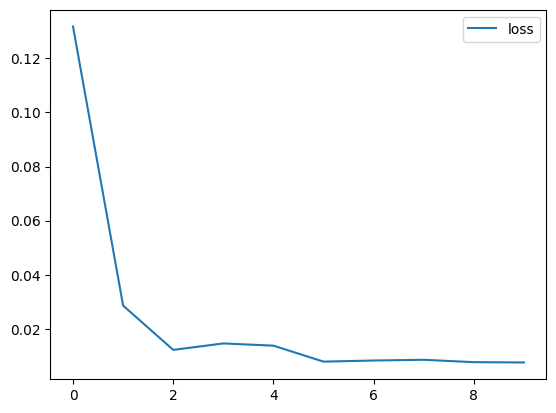

In [11]:
[plt.plot(v, label=k) for k,v in history.history.items()]
plt.legend();

2023-04-22 14:00:44.455183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [669]
	 [[{{node Placeholder/_0}}]]
2023-04-22 14:00:44.455747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [669]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 24ms/step


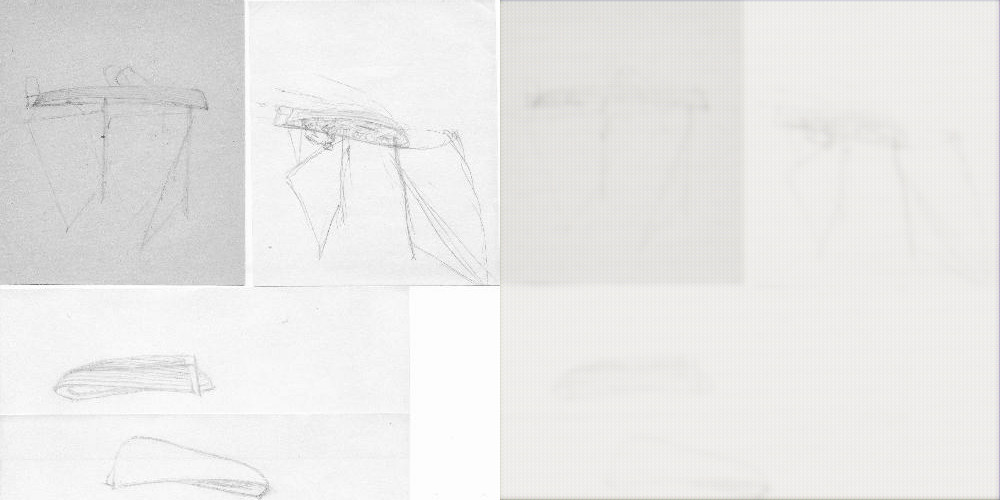

In [42]:
for i in train_ds.take(1).as_numpy_iterator():
    x, y = i
    y = y[0]
    
merge_images(Image.fromarray(((y)*255).astype('uint8')),
Image.fromarray((model.predict(x)[0]*255).astype('uint8')))